# Serial dependence
- represented from lag features
- May be useful to model `cycles`
- Use partial correlation (correlogram) to identify which lag features are ideal to include in your model
- See US unenployment dataset

- Relation may be non-linear, therefore your partial autocorrelation chart won't help
- In this case you may use lag plots to observe behaviors
- You may also use general measures of dependence that don't require linear relation, such as mutual information
- See Sunspot dataset

## Example - Flu Trends
- Dataset of doctors;  visists for the flu for weeks between 2009 and 2016
- Our goal i to forecast the number of flu cases for the comming weeks.

Two approaches
1. Forecast doctor's visits using lag features
2. Forecast doctor's visits using lags of another set of time-series: flu-related search terms as captured by Google Trends

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
# Set matplotlib and seaborn defaults
sns.set_style("whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [4]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [5]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [6]:
flu_trends = pd.read_csv("./inputs/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

In [7]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


## Time Series Plot
- Irregullar cycles, starting with winter season, but there are some exceptions (e.g., 2012)
- Peak tends to happen around new year, sometimes earlier, sometimes later
- Seasonal features constrain you to exact dates and times

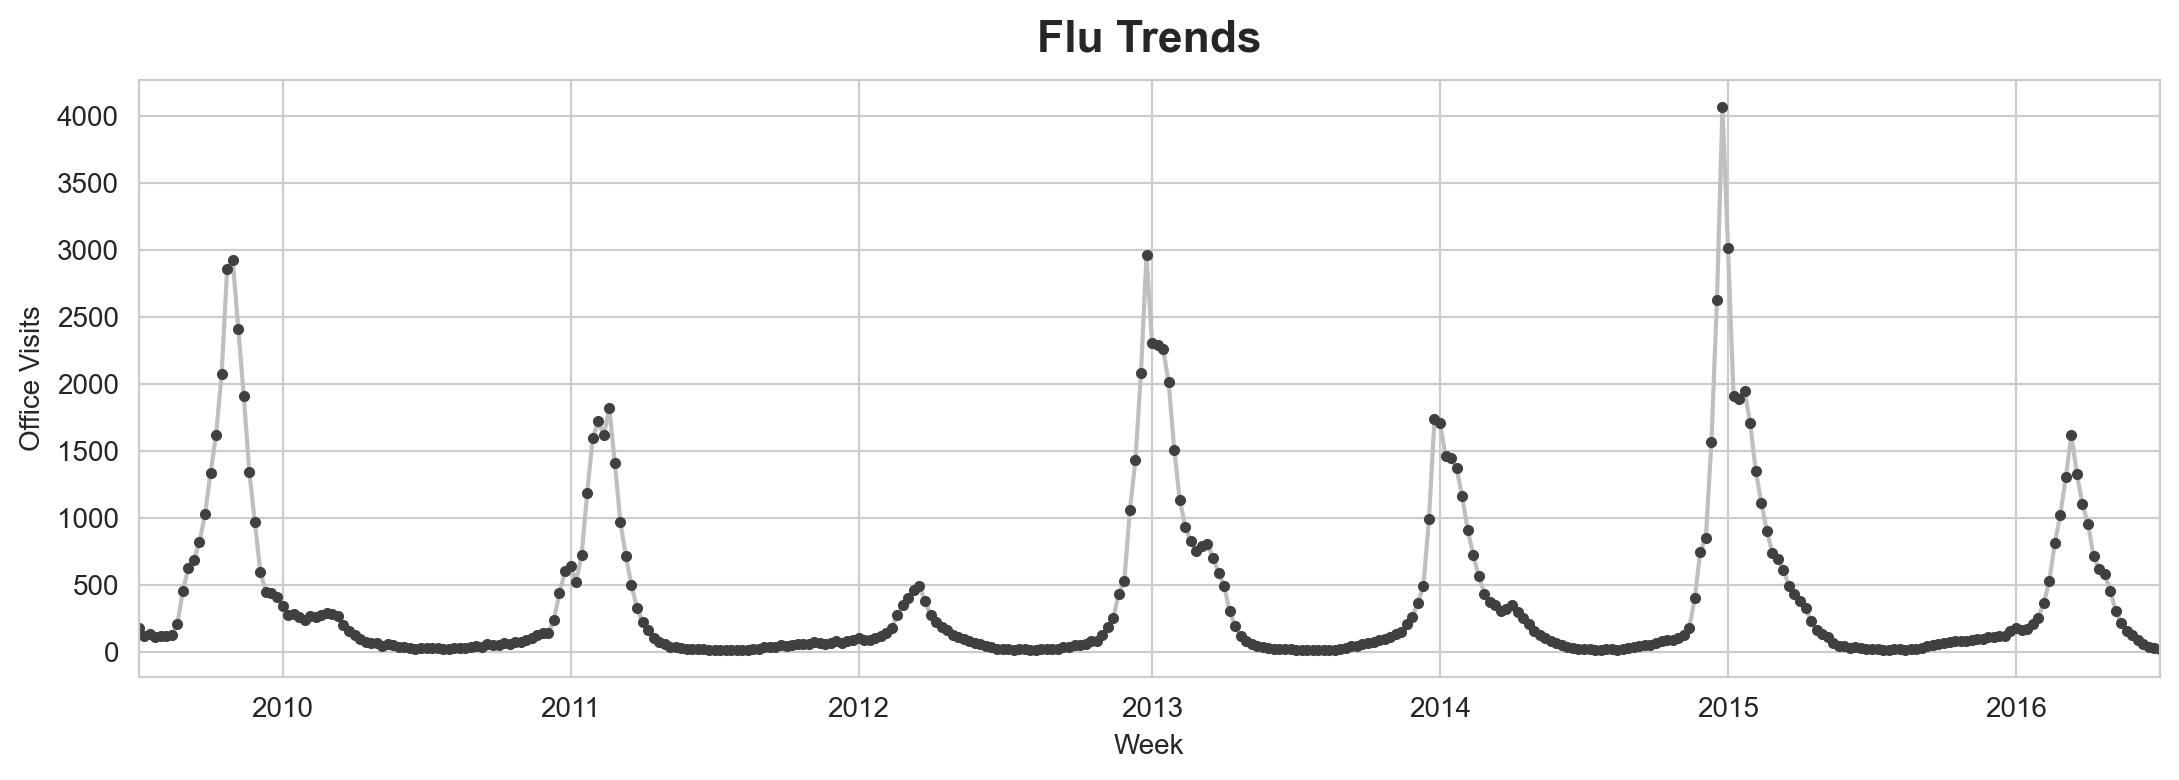

In [8]:
ax = flu_trends.FluVisits.plot(title="Flu Trends", **plot_params)
_ = ax.set(ylabel="Office Visits")

## Autocorrelation plots
- Lag plots: Lag relationship with FluVisits is mostly linear
- Partial Autocorrelations: lags 1, 2, 3 and 4 can be used

C:\ProgramData\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


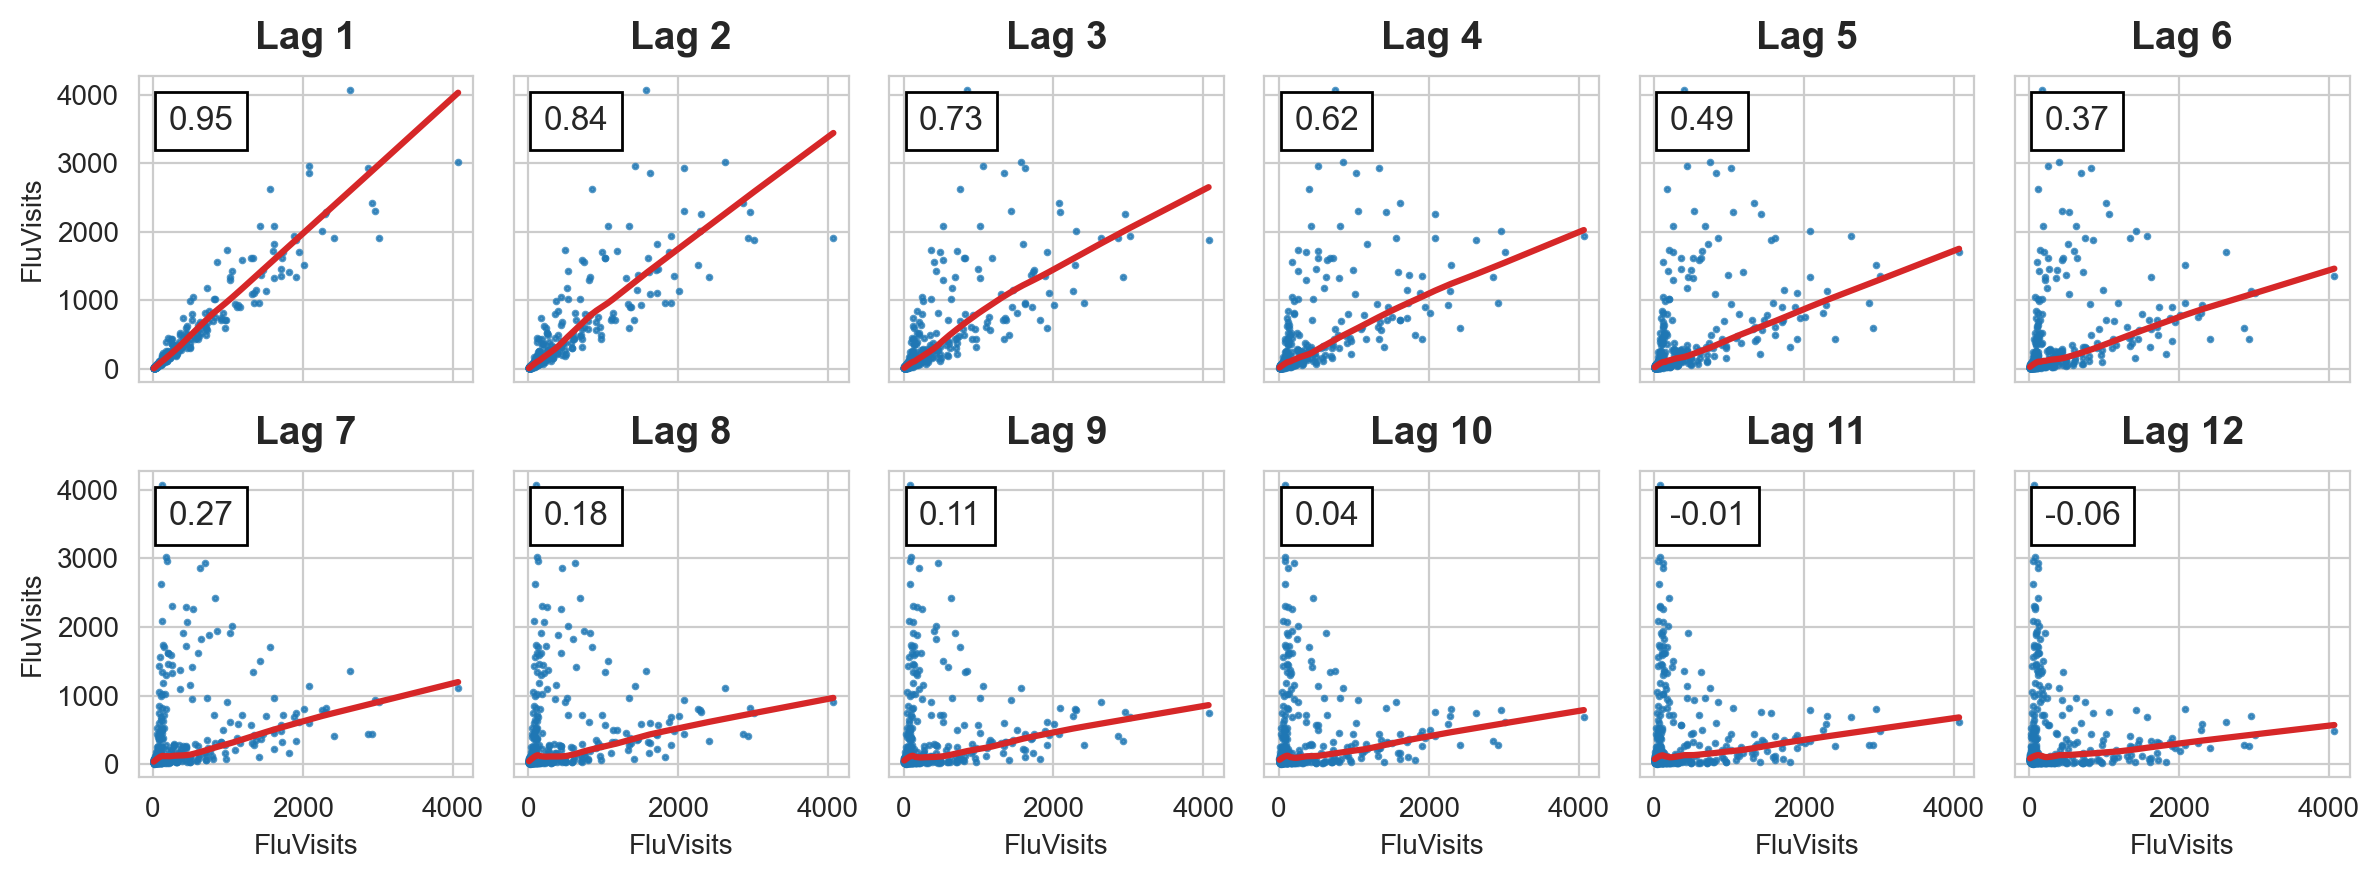

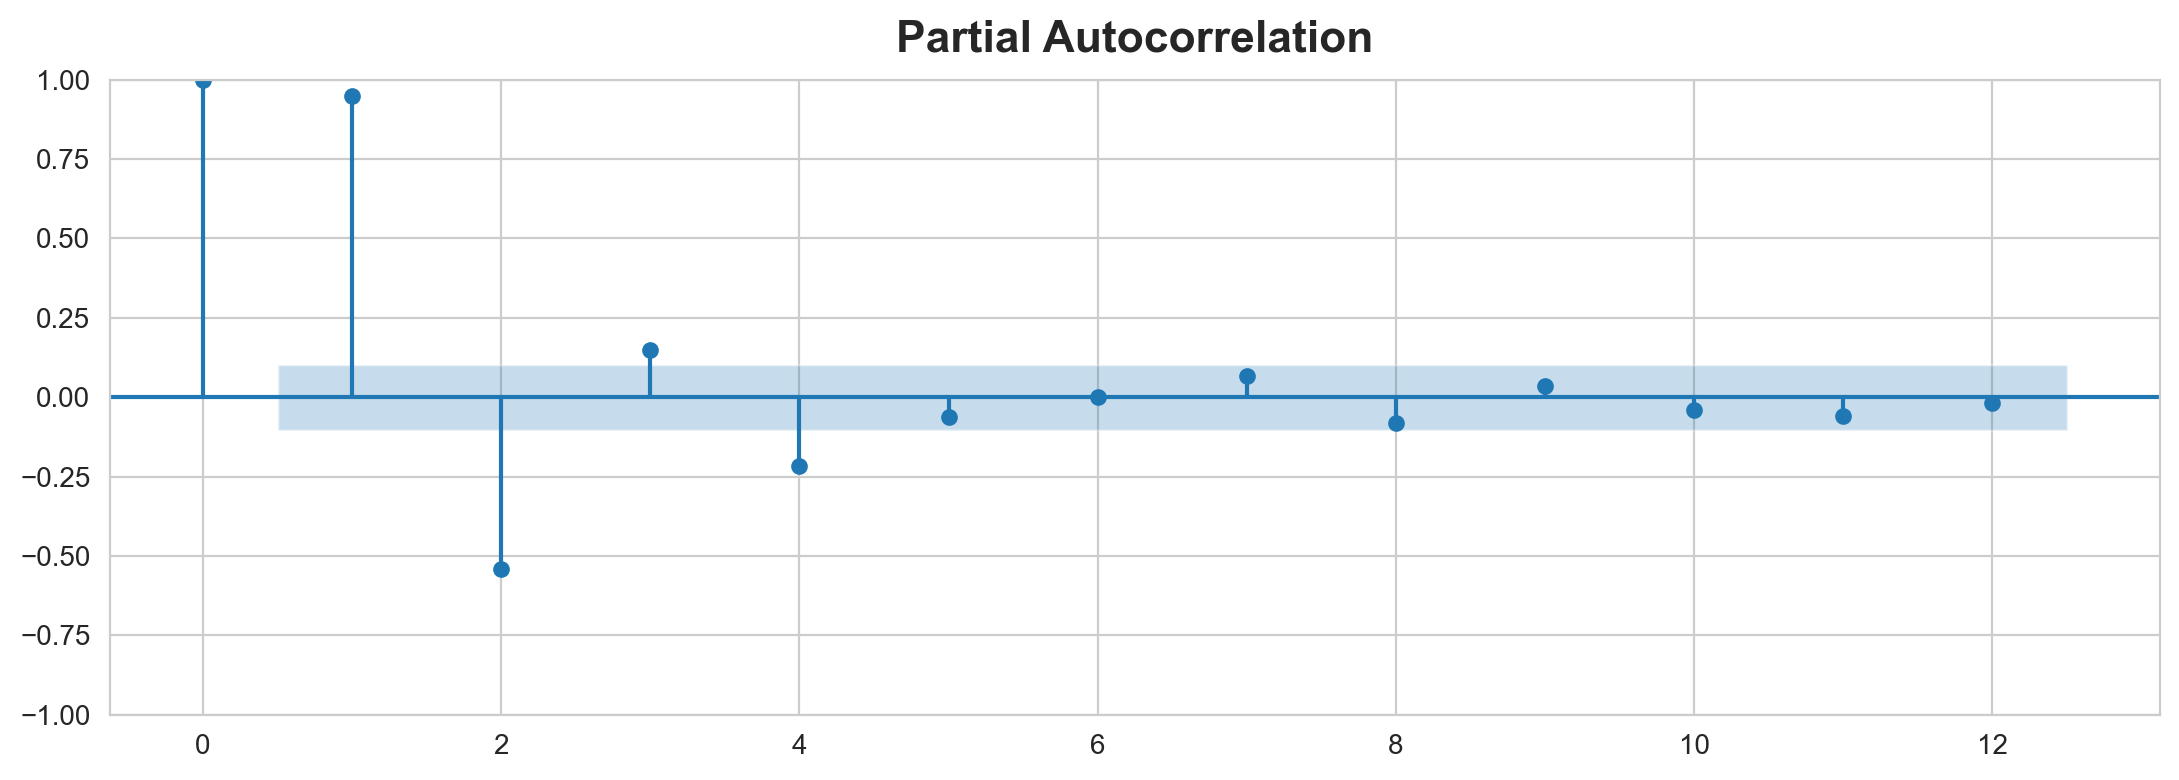

In [9]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

## Filing the missing values
- Lag features introduce missing values

In [13]:
def make_lags(ts, lags):
    lags = dict([(f"y_lag_{i}", ts.shift(i)) for i in range(1, lags+1)])
    return pd.concat(lags, axis=1)

In [15]:
X = make_lags(flu_trends["FluVisits"], lags=4)
X = X.fillna(0.0)
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


## Limitations from lag features
- Using time step features allow you to predicts as many steps as we like beyond training data
- Lag features are limited to forecasting time steps whose lagged values are available
- Using a lag 1 feature, you can only predict the next day
- Using a lag 2 feature, you can only predic tthe 2 next days
- An so on...

- Lag features also introduce... lag to the model, which can be difficult in some applications (e.g., systems control)

In [23]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Fit and predict
model = LinearRegression() # `fit_intercetp=True` since we didn't use DeterministicProcess

model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

(306, 4) (60, 4) (306,) (60,)


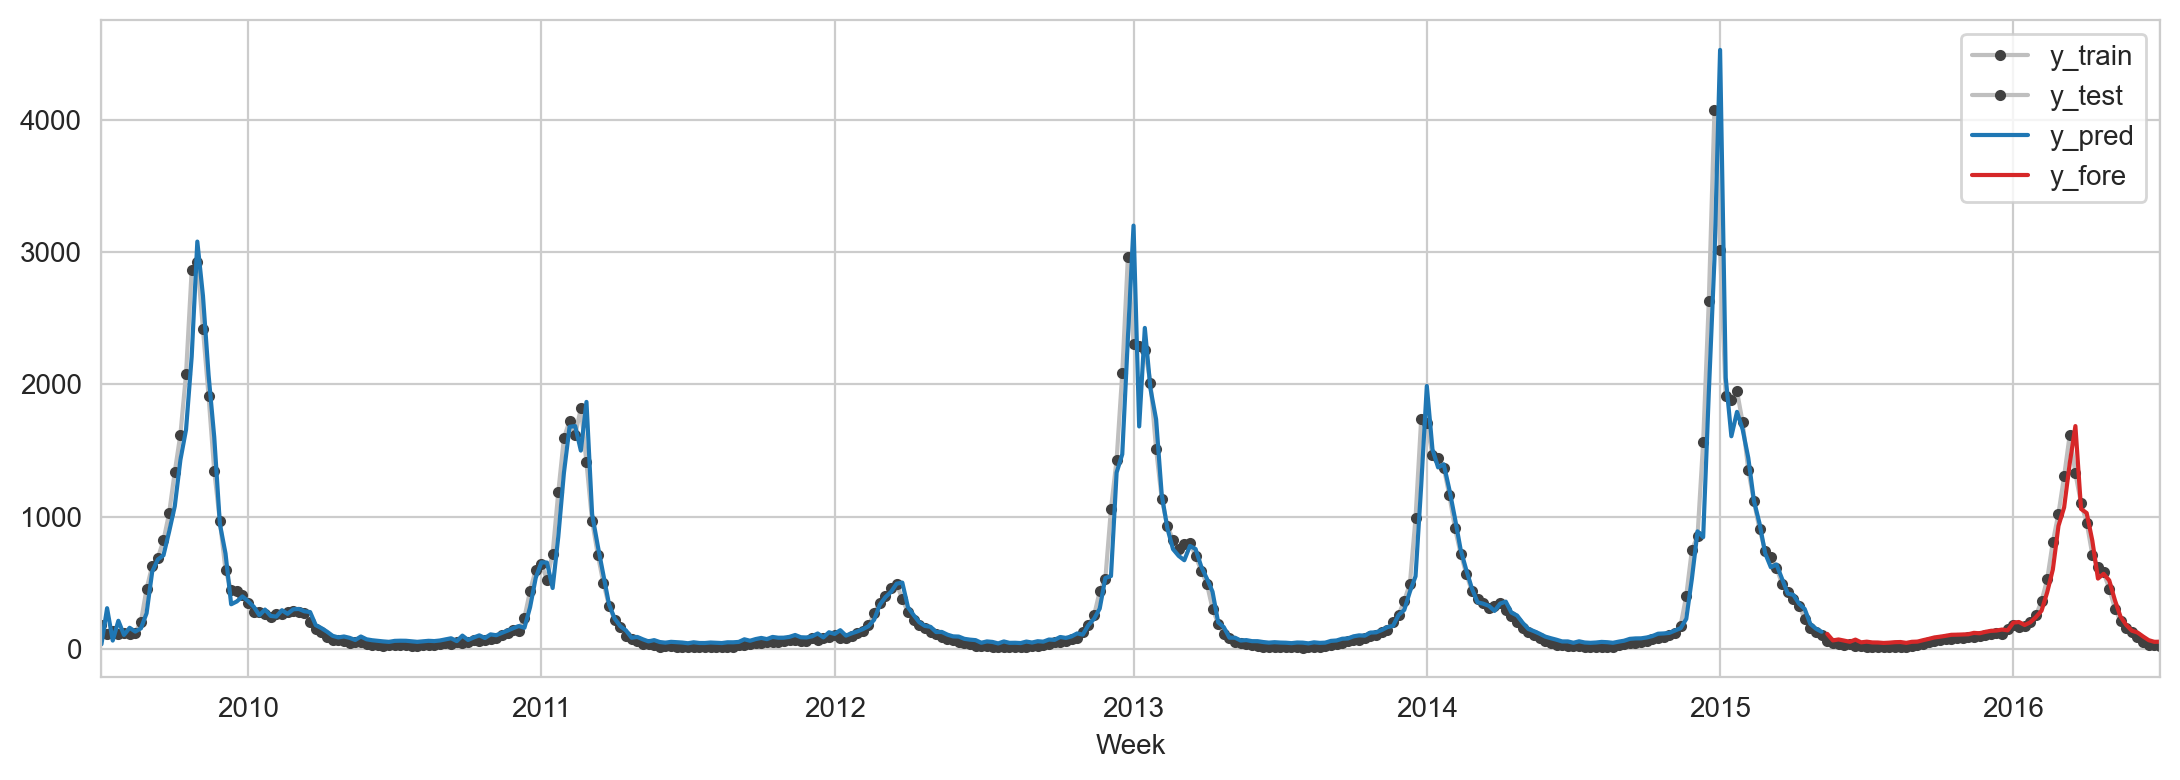

In [24]:
ax = y_train.plot(label="y_train", **plot_params)
ax = y_test.plot(label="y_test",**plot_params)
ax = y_pred.plot(label="y_pred",ax=ax)
_ = y_fore.plot(label="y_fore",ax=ax, color='C3')
ax.legend()

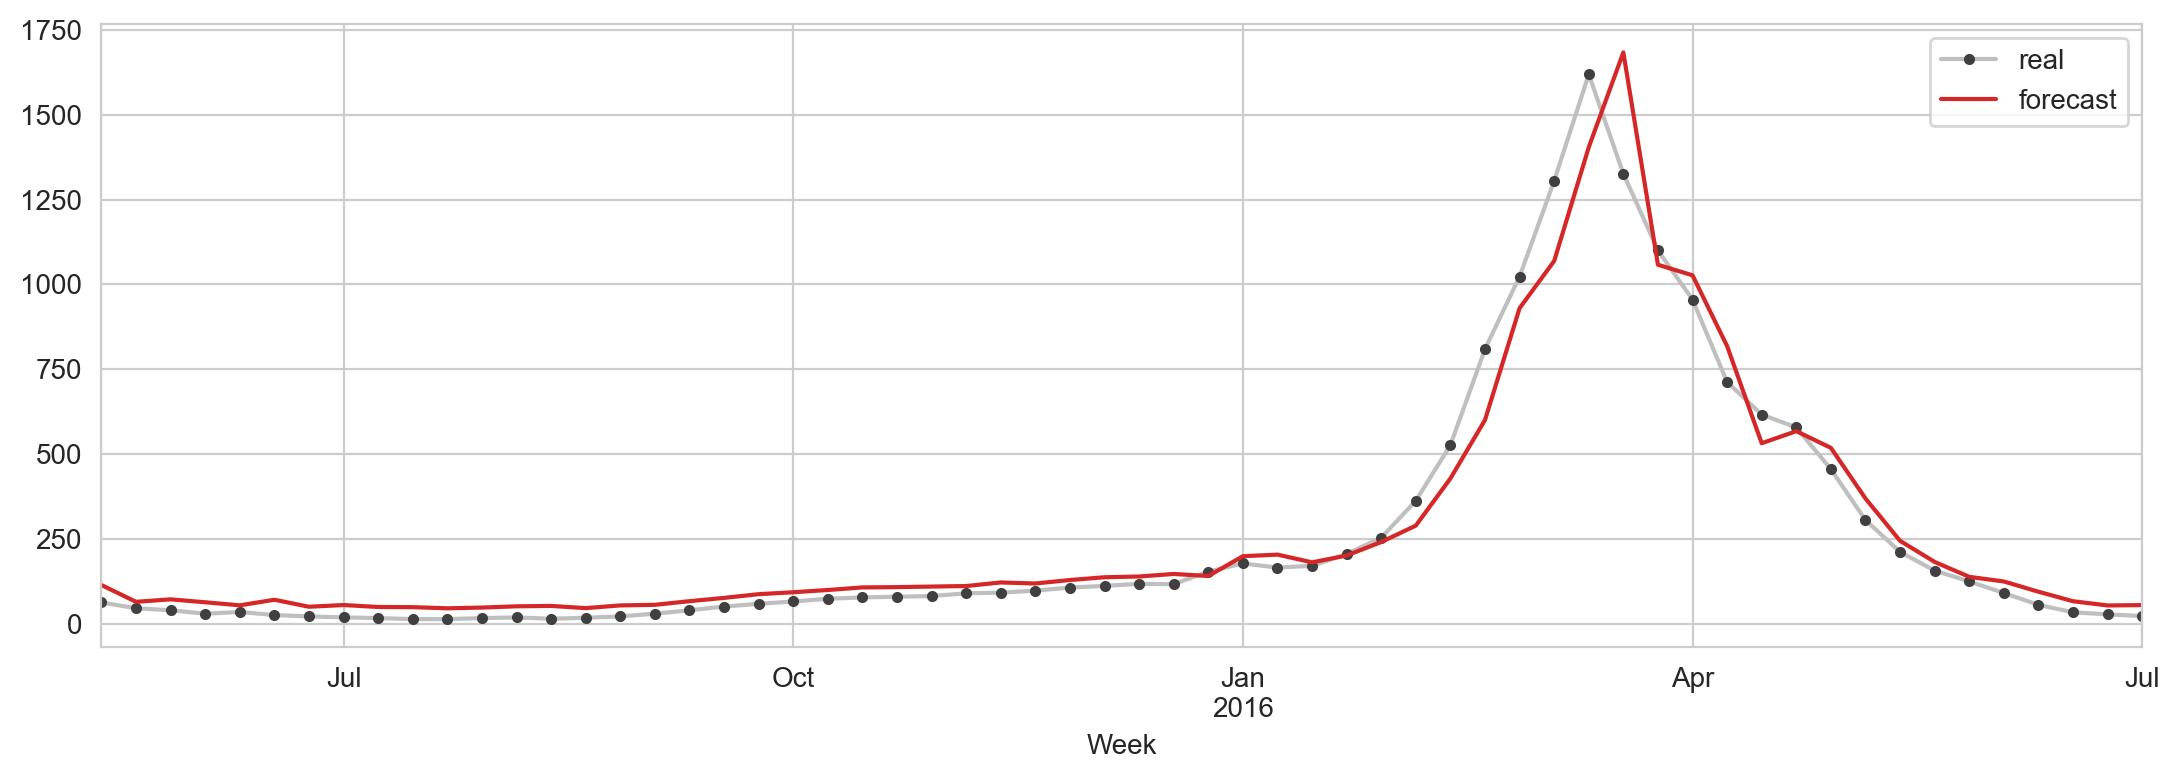

In [28]:
ax = y_test.plot(label="real",**plot_params)
_ = y_fore.plot(label="forecast",ax=ax, color='C3')
ax.legend()

## Improving the model
- By using leading indicators to provide early warning for changes in flu cases
- We will do that by using flu-related search terms in google trends
- `FluCough` against the target suggests it could be a leading indicator

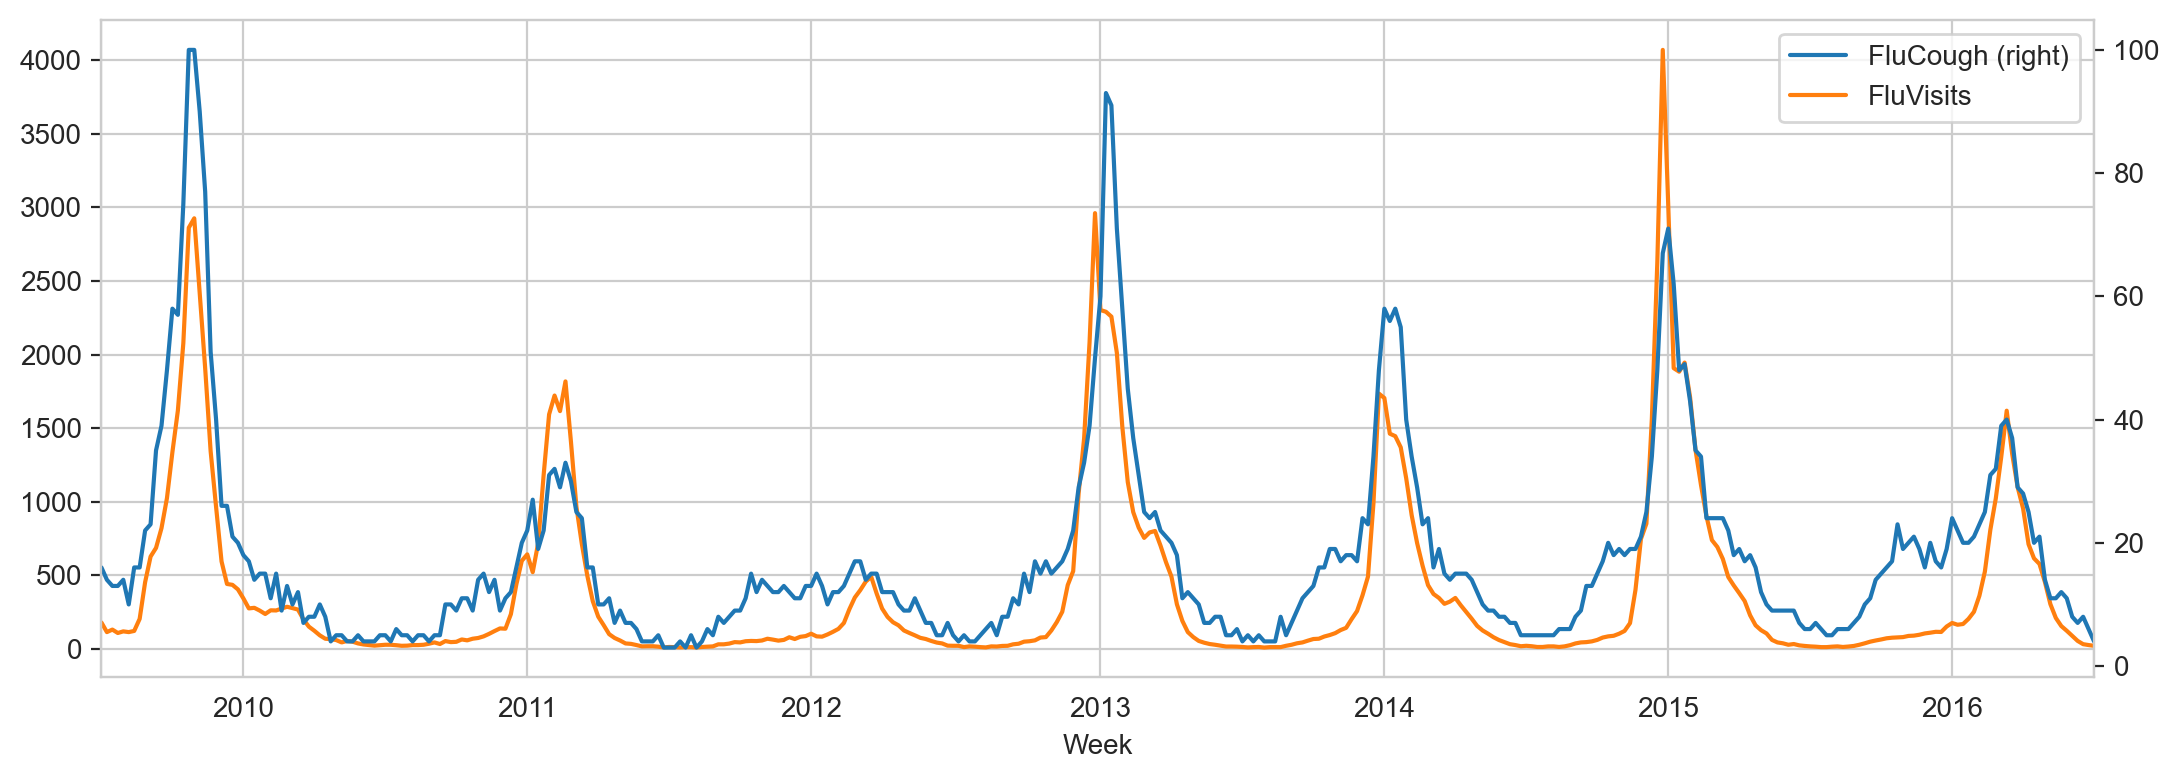

In [29]:
ax = flu_trends.plot(
    y=["FluCough","FluVisits"],
    secondary_y = "FluCough"
)

In [36]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", 
                "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target as before
X1 = make_lags(flu_trends["FluVisits"], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

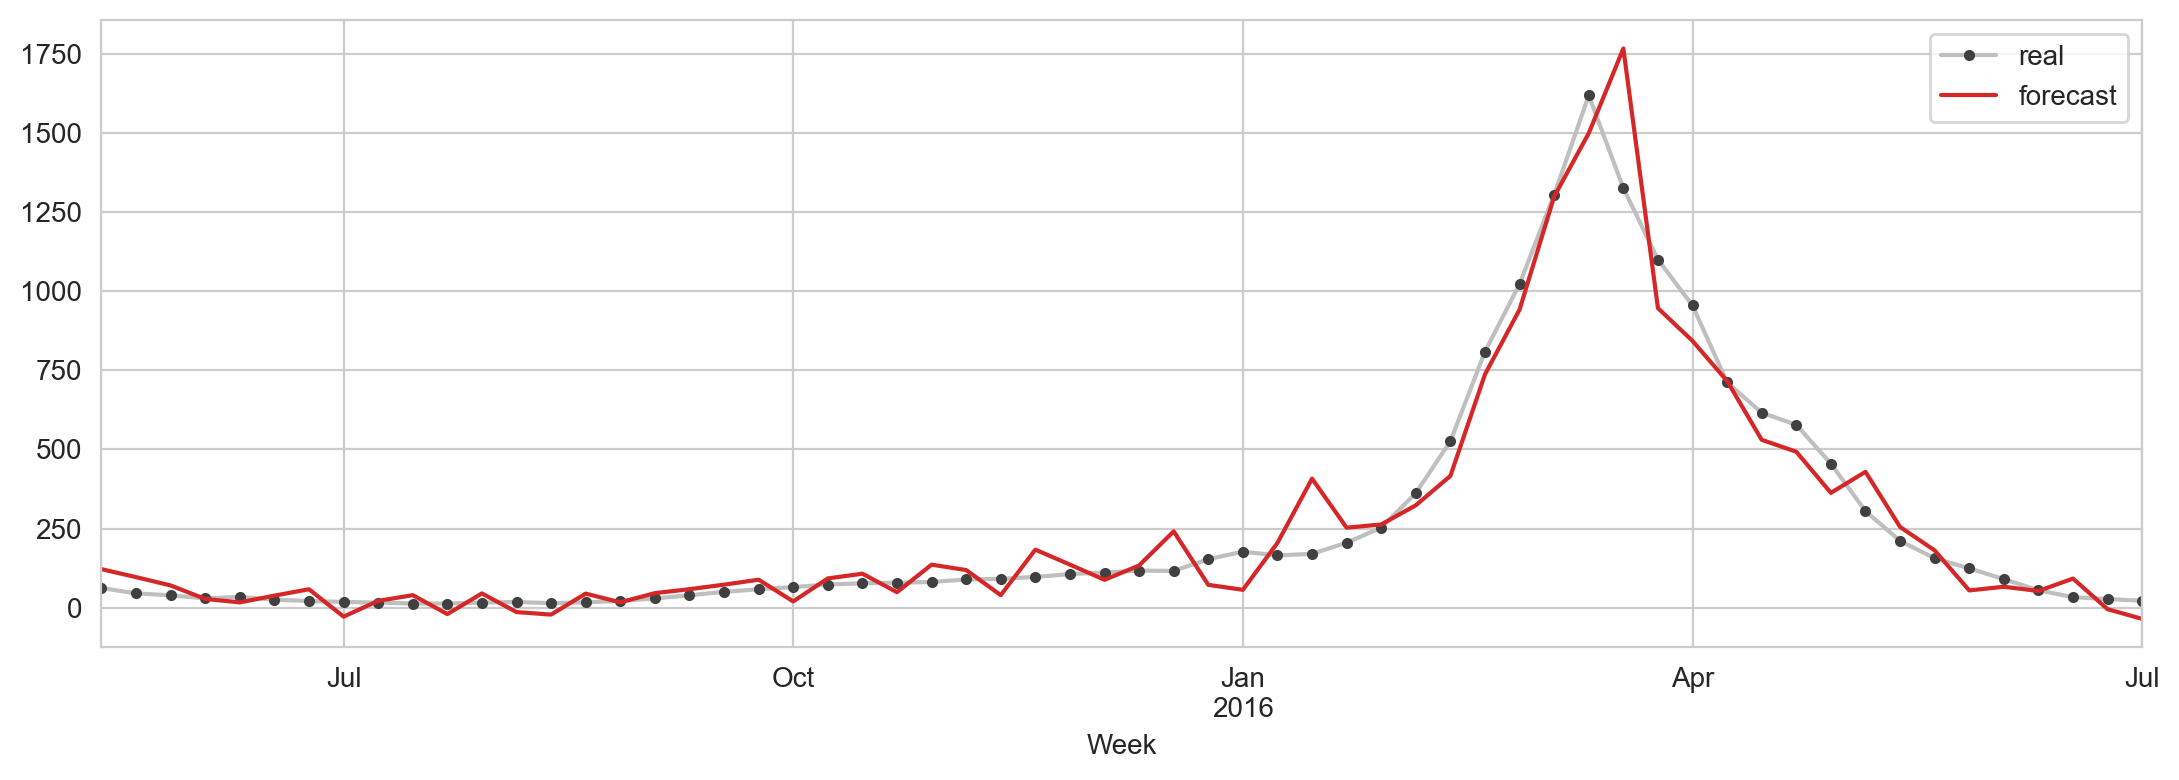

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train.values, y_train)
y_pred = pd.Series(model.predict(X_train.values), index=y_train.index)
y_fore = pd.Series(model.predict(X_test.values), index=y_test.index)

ax = y_test.plot(label="real", **plot_params)
_ = y_fore.plot(label="forecast",ax=ax, color='C3')
ax.legend()

# Conclusions
- Time series in this lesson are purely cyclic (no obvious trend or seasonality)
- It's not uncommon tthough for time series to have trend, seasonality and cycles, all at once